[Table of Contents](./table_of_contents.ipynb)

# One Dimensional Kalman Filters

In [33]:
%matplotlib inline

In [34]:
#format the book
import book_format
book_format.set_style()

Now that we understand the discrete Bayes filter and Gaussians we are prepared to implement a Kalman filter. We will do this exactly as we did the discrete Bayes filter - rather than starting with equations we will develop the code step by step based on reasoning about the problem. 

"One dimensional" means that the filter only tracks one state variable, such as position on the x-axis. In subsequent chapters we will learn a more general multidimensional form of the filter that can track many state variables simultaneously, such as position, velocity, and acceleration. Recall that we used velocity in the g-h filter to get better estimates than by tracking position alone. The same is true for the Kalman filter.

So why not just jump into the multidimensional form of the filter? To be honest, the math is difficult, and my intuitive approach to developing the filter starts to break down. This math obscures the rather simple principles that allow the Kalman filter to work.

So, in this chapter we learn how to use Gaussians to implement a Bayesian filter. That's all the Kalman filter is - a Bayesian filter that uses Gaussians. In the next chapter we will switch to a multidimensional form and the full power of the Kalman filter will be unleashed!

## Problem Description

As in the **Discrete Bayes Filter** chapter we will be tracking a moving object in a long hallway at work. Assume that in our latest hackathon someone created an RFID tracker that provides a reasonably accurate position of the dog. The sensor returns the distance of the dog from the left end of the hallway in meters. So, 23.4 would mean the dog is 23.4 meters from the left end of the hallway.

The sensor is not perfect. A reading of 23.4 could correspond to the dog being at 23.7, or 23.0. However, it is very unlikely to correspond to a position of 47.6. Testing during the hackathon confirmed this result - the sensor is 'reasonably' accurate, and while it had errors, the errors are small. Furthermore, the errors seemed to be evenly distributed on both sides of the true position; a position of 23 m would equally likely be measured as 22.9 or 23.1. Perhaps we can model this with a Gaussian.

We predict that the dog is moving. This prediction is not perfect. Sometimes our prediction will overshoot, sometimes it will undershoot. We are more likely to undershoot or overshoot by a little than a lot. Perhaps we can also model this with a Gaussian.

## Beliefs as Gaussians

We can express our belief in the dog's position with a Gaussian. Say we believe that our dog is at 10 meters, and the variance in that belief is 1 m$^2$, or $\mathcal{N}(10,\, 1)$. A plot of the pdf follows:

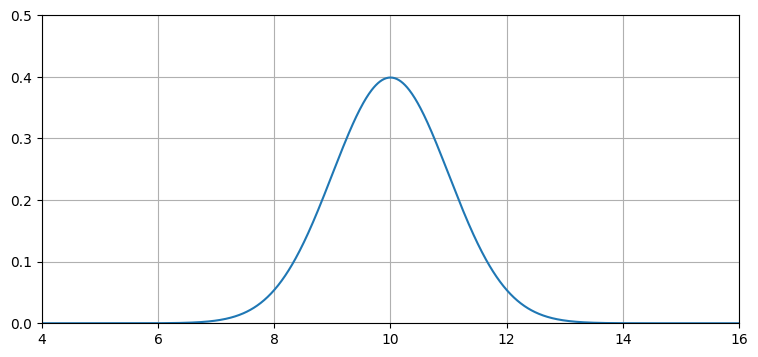

In [35]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

This plot depicts our uncertainty about the dog's position. It represents a fairly inexact belief. While we believe that it is most likely that the dog is at 10 m, any position from 9 m to 11 m or so are quite likely as well. Assume the dog is standing still, and we query the sensor again. This time it returns 10.2 m. Can we use this additional information to improve our estimate?

Intuition suggests we can. Consider: if we read the sensor 500 times and each time it returned a value between 8 and 12, all centered around 10, we should be very confident that the dog is near 10. Of course, a different interpretation is possible. Perhaps our dog was randomly wandering back and forth in a way that exactly emulated random draws from a normal distribution. But that seems extremely unlikely - I've never seen a dog do that. Let's look at 500 draws from $\mathcal N(10, 1)$:

Mean of readings is 9.939


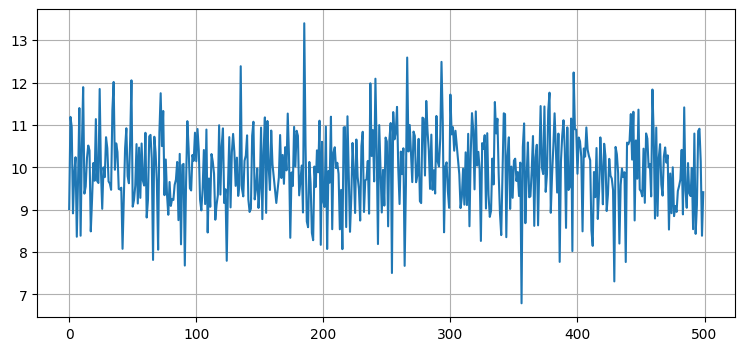

In [36]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

Eyeballing this confirms our intuition - no dog moves like this. However, noisy sensor data certainly looks this way.  The computed mean of the readings is almost exactly 10. Assuming the dog is standing still, we say the dog is at position 10 with a variance of 1.

## Tracking with Gaussian Probabilities

The discrete Bayes filter used a histogram of probabilities to track the dog. Each bin in the histogram represents a position, and the value is the probability of the dog being in that position.

Tracking was performed with a cycle of predictions and updates. We used the equations 

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{Update}
\end{aligned}$$

to compute the new probability distributions. Recall that $\bar{\mathbf x}$ is the *prior*, $\mathcal L$ is the *likelihood* of a measurement given the prior $\bar{\mathbf x}$, $f_{\mathbf x}(\bullet)$ is the *process model*, and $\ast$ denotes *convolution*. $\mathbf x$ is bold to denote that it is a histogram of numbers, or a vector.

This method works, but led to histograms that implied the dog could be in multiple places at once. Also, the computations are very slow for large problems.

Can we replace $\mathbf x$, the histogram, with a Gaussian $\mathcal N(x, \sigma^2)$? Absolutely! We've learned how to express belief as a Gaussian. A Gaussian, which is a single number pair $\mathcal N(\mu, \sigma^2),$ can replace an entire histogram of probabilities:

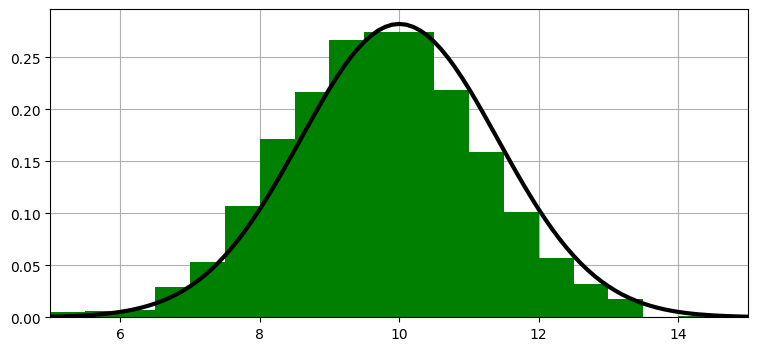

In [37]:
import kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

I hope you see the power of this. We can replace hundreds to thousands of numbers with a single pair of numbers: $x = \mathcal N(\mu, \sigma^2)$. 

The tails of the Gaussian extend to infinity on both sides, so it incorporates arbitrarily many bars in the histogram. If this represents our belief in the position of the dog in the hallway, this one Gaussian covers the entire hallway (and the entire universe on that axis). We think that it is likely the dog is at 10, but he could be at 8, 14, or, with infinitesimally small probability, at 10$^{80}$. 

In this chapter we replace histograms with Gaussians:

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

where $\oplus$ and $\otimes$ is meant to express some unknown operator on Gaussians. I won't do it in the rest of the book, but the subscript indicates that $x_\mathcal{N}$ is a Gaussian. 

The discrete Bayes filter used convolution for the prediction. We showed that it used the *total probabability theorem*, computed as a sum, so maybe we can add the Gaussians. It used multiplications to incorporate the measurement into the prior, so maybe we can multiply the Gaussians. Could it be this easy:

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

This will only work if the sum and product of two Gaussians is another Gaussian. Otherwise after the first epoch $x$ would not be Gaussian, and this scheme falls apart.

## Predictions with Gaussians

We use Newton's equation of motion to compute current position based on the current velocity and previous position:

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

I've dropped the notation $f_x(\bullet)$ in favor of $f_x$ to keep the equations uncluttered. 

If the dog is at 10 m, his velocity is 15 m/s, and the epoch is 2 seconds long, we have

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

We are uncertain about his current position and velocity, so this will not do. We need to express the uncertainty with a Gaussian.

Position is easy. We define $x$ as a Gaussian. If we think the dog is at 10 m, and the standard deviation of our uncertainty is 0.2 m, we get $x=\mathcal N(10, 0.2^2)$.

What about our uncertainty in his movement? We define $f_x$ as a Gaussian. If the dog's velocity is 15 m/s, the epoch is 1 second, and the standard deviation of our uncertainty is 0.7 m/s, we get $f_x = \mathcal N (15, 0.7^2)$.

The equation for the prior is 

$$\bar x = x + f_x$$

What is the sum of two Gaussians? In the last chapter I proved that:

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

This is fantastic news; the sum of two Gaussians is another Gaussian! 

The math works, but does this make intuitive sense?  Think of the physical representation of this abstract equation. We have 

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$

If we add these we get:

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

It makes sense that the predicted position is the previous position plus the movement. What about the variance? It is harder to form an intuition about this. However, recall that with the `predict()` function for the discrete Bayes filter we always lost information. We don't really know where the dog is moving, so the confidence should get smaller (variance gets larger). $\sigma_{f_x}^2$ is the amount of uncertainty added to the system due to the imperfect prediction about the movement, and so we would add that to the existing uncertainty. 

Let's take advantage of the `namedtuple` class in Python's `collection` module to implement a Gaussian object. We could implement a Gaussian using a tuple, where $\mathcal N(10, 0.04)$ is implemented in Python as `g = (10., 0.04)`. We would access the mean with `g[0]` and the variance with `g[1]`.

`namedtuple` works the same as a tuple, except you provide it with a type name and field names. It's not important to understand, but I modified the `__repr__` method to display its value using the notation in this chapter. 

In [38]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

Now we can create a print a Gaussian with:

In [39]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


We can access the mean and variance with either subscripts or field names:

In [40]:
g1.mean, g1[0], g1[1], g1.var

(3.4, 3.4, 10.1, 10.1)

Here is our implementation of the predict function, where `pos` and `movement` are Gaussian tuples in the form ($\mu$, $\sigma^2$):

In [41]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

Let's test it. What is the prior if the intitial position is the Gaussian $\mathcal N(10, 0.2^2)$ and the movement is the Gaussian $\mathcal N (15, 0.7^2)$?

In [42]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

The prior states that the dog is at 25 m with a variance of 0.53 m$^2$, which is what we computed by hand.

## Updates with Gaussians

The discrete Bayes filter encodes our belief about the position of our dog in a histogram of probabilities. The distribution is discrete and multimodal. It can express strong belief that the dog is in two positions at once, and the positions are discrete.

We are proposing that we replace the histogram with a Gaussian. The discrete Bayes filter used this code to compute the posterior:


```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

which is an implementation of the equation:

$$x = \| \mathcal L\bar x \|$$

We've just shown that we can represent the prior with a Gaussian. What about the likelihood? The likelihood is the probability of the measurement given the current state. We've learned how to represent measurements as Gaussians. For example, maybe our sensor states that the dog is at 23 m, with a standard deviation of 0.4 meters. Our measurement, expressed as a likelihood, is $z = \mathcal N (23, 0.16)$.

Both the likelihood and prior are modeled with Gaussians. Can we multiply Gaussians? Is the product of two Gaussians another Gaussian?

Yes to the former, and almost to the latter! In the last chapter I proved that the product of two Gaussians is proportional to another Gausian. 

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

We can immediately infer several things. If we normalize the result, the product is another Gaussian. If one Gaussian is the likelihood, and the second is the prior, then the mean is a scaled sum of the prior and the measurement. The variance is a combination of the variances of the prior and measurement. Finally, the variances are completely unaffected by the values of the mean!

We put this in Bayesian terms like so:

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

If we implemented that in a function `gaussian_multiply()` we could implement our filter's update step as

In [43]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

Perhaps this would be clearer if we used more specific names:

```python
def update_dog(dog_pos, measurement):
    estimated_pos = gaussian_multiply(measurement, dog_pos)
    return estimated_pos  
```

That is less abstract, which perhaps helps with comprehension, but it is poor coding practice. We are writing a Kalman filter that works for any problem, not just tracking dogs in a hallway, so we won't use variable names with 'dog' in them. Also, this form obscures the fact that we are multiplying the likelihood by the prior.

We have the majority of our filter implemented, but I fear this step is still a bit confusing. I've asserted that we can multiply Gaussians and that it correctly performs the update step, but why is this true? Let's take a detour and spend some time multiplying Gaussians.

### Understanding Gaussian Multiplication

Let's plot the pdf of $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$. Can you determine its shape without looking at the result? What should the new mean be? Will the curve be wider, narrower, or the same as $\mathcal{N}(10,\, 1)$?

𝒩(μ=10.000, 𝜎²=0.500)


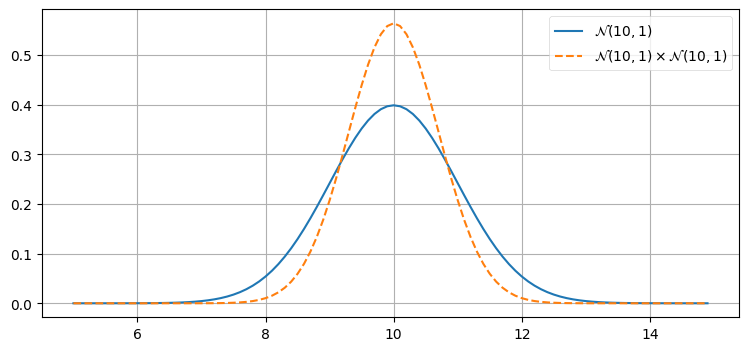

In [44]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

The result of the multiplication is taller and narrow than the original Gaussian but the mean is unchanged. Does this match your intuition?

Think of the Gaussians as two measurements. If I measure twice and get 10 meters each time, I should conclude that the length is close to 10 meters. Thus the mean should be 10. It would make no sense to conclude the length is actually 11, or 9.5. Also, I am more confident with two measurements than with one, so the variance of the result should be smaller. 

"Measure twice, cut once" is a well known saying. Gaussian multiplication is a mathematical model of this physical fact. 

I'm unlikely to get the same measurement twice in a row. Now let's plot the pdf of $\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$. What do you think the result will be? Think about it, and then look at the graph.

In [45]:
m = 3.3
f'$({m},{m})$'

'$(3.3,3.3)$'

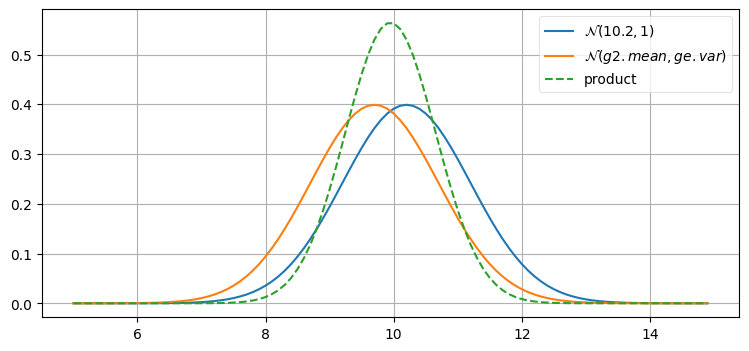

In [46]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$' + f'$({g1.mean},{g1.var})$')

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$' + '$({g2.mean},{ge.var})$')

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    plt.show()
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

If you ask two people to measure the distance of a table from a wall, and one gets 10.2 meters, and the other got 9.7 meters, your best guess must be the average, 9.95 meters if you trust the skills of both equally.

Recall the g-h filter. We agreed that if I weighed myself on two scales, and the first read 160 lbs while the second read 170 lbs, and both were equally accurate, the best estimate was 165 lbs. Furthermore I should be a bit more confident about 165 lbs vs 160 lbs or 170 lbs because I now have two readings, both near this estimate, increasing my confidence that neither is wildly wrong. 

This becomes counter-intuitive in more complicated situations, so let's consider it further. Perhaps a more reasonable assumption would be that one person made a mistake, and the true distance is either 10.2 or 9.7, but certainly not 9.95. Surely that is possible. But we know we have noisy measurements, so we have no reason to think one of the measurements has no noise, or that one person made a gross error that allows us to discard their measurement. Given all available information, the best estimate must be 9.95.

In the update step of the Kalman filter we are not combining two measurements, but one measurement and the prior, our estimate before incorporating the measurement. We went through this logic for the g-h filter. It doesn't matter if we are incorporating information from two measurements, or a measurement and a prediction, the math is the same. 

Let's look at that. I'll create a fairly inaccurate prior of $\mathcal N(8.5, 1.5)$ and a more accurate measurement of $\mathcal N(10.2, 0.5).$ By "accurate" I mean the sensor variance is smaller than the prior's variance, not that I somehow know that the dog is closer to 10.2 than 8.5. Next I'll plot the reverse relationship: an accurate prior of $\mathcal N(8.5, 0.5)$ and a inaccurate measurement of $\mathcal N(10.2, 1.5)$.

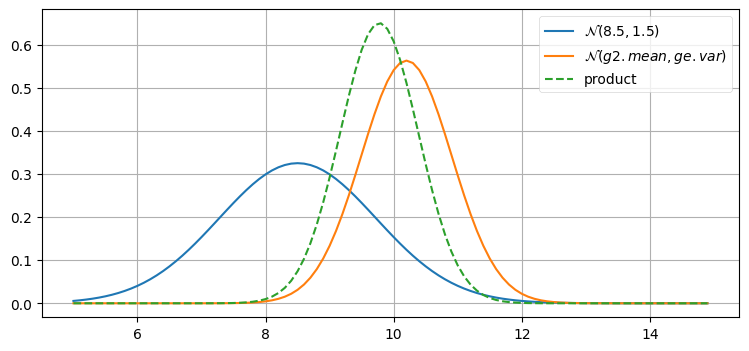

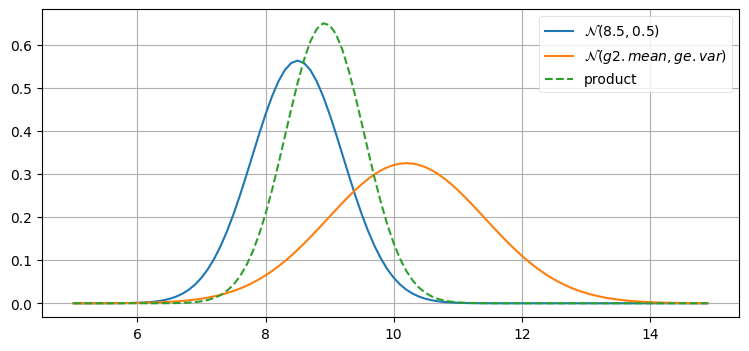

In [47]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

The result is a Gaussian that is taller than either input. This makes sense - we have incorporated information, so our variance should have been reduced. And notice how the result is far closer to the the input with the smaller variance. We have more confidence in that value, so it makes sense to weight it more heavily.

It *seems* to work, but is it really correct? There is more to say about this, but I want to get a working filter going so you can experience it in concrete terms. After that we will revisit Gaussian multiplication and determine why it is correct.

### Interactive Example

This interactive code provides sliders to alter the mean and variance of two Gaussians that are being multiplied together. As you move the sliders the plot is redrawn. Place your cursor inside the code cell and press CTRL+Enter to execute it.

In [48]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

## First Kalman Filter

Let's get back to concrete terms and implement a Kalman filter. We've implemented the `update()` and `predict()` functions. We just need to write some boilerplate code to simulate a dog and create the measurements. I've put a `DogSimulation` class in `kf_internal` to avoid getting distracted with that task. 

This boilerplate code sets up the problem by definine the means, variances, and generating the simulated dog movement.

In [49]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

And here is the Kalman filter.

In [50]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


Here is an animation of the filter. Predictions are plotted with a red triangle. After the prediction, the filter receives the next measurement, plotted as a black circle. The filter then forms an estimate part way between the two. 

I've plotted the prior (labeled *prediction*), the measurements, and the filter output. For each iteration of the loop we form a prior, take a measurement, form a likelihood from the measurement, and then incorporate the likelihood into the prior. 

If you look at the plot you can see that the filter estimate is always between the measurement and prediction. Recall that for the g-h filter we argued that the estimate must always be between the measurement and prior. It makes no sense to choose a value outside of the two values. If I predict I am at 10, but measure that I am at 9, it would be foolish to decide that I must be at 8, or 11.

## Code Walkthrough

Now let's walk through the code.

```python
process_var = 1.
sensor_var = 2.
```
 
These are the variances for the process model and sensor. The meaning of sensor variance should be clear - it is how much variance there is in each measurement. The process variance is how much error there is in the process model. We are predicting that at each time step the dog moves forward one meter. Dogs rarely do what we expect, and things like hills or the whiff of a squirrel will change his progress. If this was a robot responding to digital commands the performance would be much better, and perhaps the variance would be $\sigma^2=.05$. These are not 'magic' numbers; the square root of the variance is the distance error in meters. It is easy to get a Kalman filter working by just plugging in numbers, but if the numbers do not reflect reality the performance of the filter will be poor.

```python
x = gaussian(0., 20.**2)
```

This is the dog's initial position expressed as a Gaussian. The position is 0 meters, and the variance to 400 m$^2$, which is a standard deviation of 20 meters. You can think of this as saying "I believe with 99.7% accuracy the position is 0 plus or minus 60 meters". This is because with Gaussians ~99.7% of values fall within $\pm3\sigma$ of the mean.

```python
process_model = gaussian(velocity, process_var)
```

This is the process model - the description of how we think the dog moves. How do I know the velocity? Magic? Consider it a prediction, or perhaps we have a secondary velocity sensor. If this is a robot then this would be a control input to the robot. In subsequent chapters we will learn how to handle situations where you don't have a velocity sensor or input, so please accept this simplification for now.

Next we initialize the simulation and create 10 measurements:

```python
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

zs = [dog.move_and_sense() for _ in range(10)]
```

Now we enter our `predict() ... update()` loop.

```python
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
```

The first time through the loop `prior` is `(1.0, 401.0)`, as can be seen in the printed table. After the prediction, we believe that we are at 1.0, and the variance is now 401, up from 400. The variance got worse, which is what always happens during the prediction step because it involves a loss of information.

Then we call the update function using `prior` as the current position.

For this I get this as the result: `pos = (1.352, 1.990), z = 1.354`.

What is happening? The dog is actually at 1.0 but the measured position is 1.354 due to sensor noise. That is pretty far from the predicted value of 1. The variance of the prior is 401 m$^2$. A large variance implies that confidence is very low, so the filter estimates the position to be very close to the measurement: 1.352.

Now look at the variance: 1.99 m$^2$. It has dropped tremendously from 401 m$^2$. Why? Well, the RFID has a reasonably small variance of 2.0 m$^2$, so we trust it far more than the prior. However, the previous belief does contain a bit of useful information, so our variance is now slightly smaller than 2.0.

Now the software loops, calling `predict()` and `update()` in turn. By the end the final estimated position is 15.053 vs the actual position of 14.838. The variance has converged to 1.0 m$^2$. 

Now look at the plot. The noisy measurements are plotted with black circles, and the filter results are drawn with a solid blue line. Both are quite noisy, but notice how much noisier the measurements are. I plotted the prediction (prior) with red triangles. The estimate always lies between the prior and the measurement. This is your first Kalman filter and it seems to work!

The filtering is implemented in only a few lines of code. Most of the code is either initialization, storing of data, simulating the dog movement, and printing results. The code that performs the filtering is very succinct:

```python
prior = predict(x, process_model)
likelihood = gaussian(z, sensor_var)
x = update(prior, likelihood)
```

If we didn't use the `predict` and `update` functions the code might be:

```python
for z in zs:
    # predict
    dx = velocity*dt
    pos = pos + dx
    var = var + process_var

    # update
    pos  = (var*z + sensor_var*pos) / (var + sensor_var)
    var = (var * sensor_var) / (var + sensor_var)
```    

Just 5 lines of very simple math implements the entire filter!

In this example I only plotted 10 data points so the output from the print statements would not overwhelm us. Now let's look at the filter's performance with more data. The variance is plotted as a lightly shaded yellow area between dotted lines. I've increased the size of the process and sensor variance so they are easier to see on the chart - for a real Kalman filter of course you will not be randomly changing these values.

In [51]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


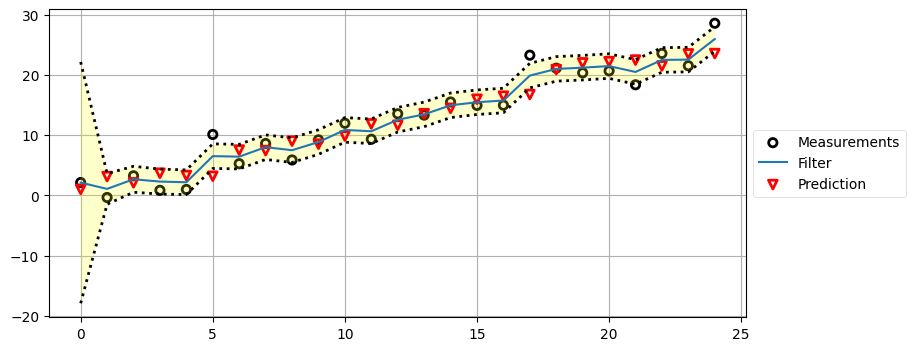

In [52]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

Here we can see that the variance converges to 2.1623 in 9 steps. This means that we have become very confident in our position estimate. It is equal to $\sigma=1.47$ meters. Contrast this to the sensor's $\sigma=2.12$ meters. The first few measurements are unsure due to our uncertainty of the initial position, but the filter quickly converges to an estimate with lower variance than the sensor!

This code fully implements a Kalman filter. If you have tried to read the literature you are perhaps surprised, because this looks nothing like the endless pages of math in those books.  So long as we worry about *using* the equations rather than *deriving* them the topic is approachable. Moreover, I hope you'll agree that you have a decent intuitive grasp of what is happening. We represent beliefs with Gaussians, and they get better over time because more measurements means we have more data to work with.

### Exercise: Modify Variance Values

Modify the values of `process_var` and `sensor_var` and note the effect on the filter and on the variance. Which has a larger effect on the variance convergence? For example, which results in a smaller variance:

```python
process_var = 40
sensor_var = 2
```
    
or:

```python
process_var = 2
sensor_var = 40
```

### KF Animation

If you are reading this in a browser you will be able to see an animation of the filter tracking the dog directly below this sentence.
<img src='animations/05_dog_track.gif'>

The top plot shows the output of the filter in green, and the measurements with a dashed red line. The bottom plot shows the Gaussian at each step. 

When the track first starts you can see that the measurements varies quite a bit from the initial prediction. At this point the Gaussian probability is small (the curve is low and wide) so the filter does not trust its prediction. As a result, the filter adjusts its estimate a large amount. As the filter innovates you can see that as the Gaussian becomes taller, indicating greater certainty in the estimate, the filter's output becomes very close to a straight line. At `x = 15` and greater you can see that there is a large amount of noise in the measurement, but the filter does not react much to it compared to how much it changed for the first noisy measurement.

## Kalman Gain

We see that the filter works. Now let's go back to the math to understand what is happening. The posterior $x$ is computed as the likelihood times the prior ($\mathcal L \bar x$), where both are Gaussians.

Therefore the mean of the posterior is given by:

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

I use the subscript $z$ to denote the measurement. We can rewrite this as:

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

In this form it is easy to see that we are scaling the measurement and the prior by weights: 

$$\mu = W_1 \mu_z + W_2 \bar\mu$$


The weights sum to one because the denominator is a normalization term. We introduce a new term, $K=W_1$, giving us:

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

where

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

$K$ is the *Kalman gain*. It's the crux of the Kalman filter. It is a scaling term that chooses a value partway between $\mu_z$ and $\bar\mu$.

Let's work a few examples. If the measurement is nine times more accurate than the prior, then $\bar\sigma^2 = 9\sigma_z^2$, and

$$\begin{aligned}
\mu&=\frac{9 \sigma_z^2 \mu_z + \sigma_z^2\, \bar\mu} {9 \sigma_z^2 + \sigma_\mathtt{z}^2} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$

Hence $K = \frac 9 {10}$, and to form the posterior we take nine tenths of the measurement and one tenth of the prior. 

If the measurement and prior are equally accurate, then $\bar\sigma^2 = \sigma_z^2$ and

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$

which is the average of the two means. It makes intuitive sense to take the average of two equally accurate values.

We can also express the variance in terms of the Kalman gain:

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

We can understand this by looking at this chart:

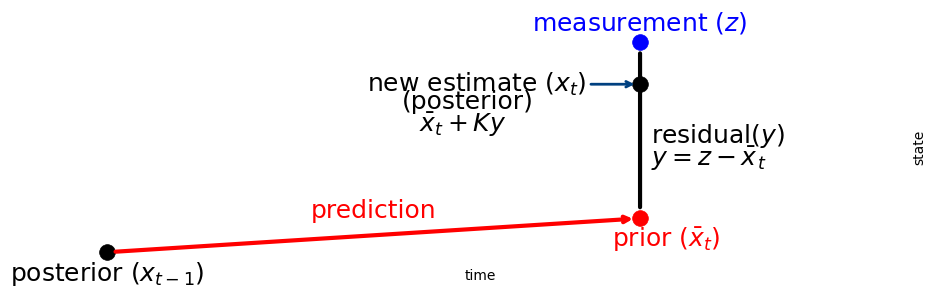

In [53]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

The Kalman gain $K$ is a scale factor that chooses a value along the residual. This leads to an alternative but equivalent implementation for `update()` and `predict()`:

In [54]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

Why have I written it in this form, and why have I chosen these terrible variable names? A few related reasons. A majority of books and papers present the Kalman filter in this form. My derivation of the filter from Bayesian principles is not unknown, but it is not used nearly as often. Alternative derivations naturally lead to this form of the equations. Also, the equations for the multivariate Kalman filter look almost exactly like these equations. So, you need to learn and understand them. 

Where do the names `z`, `P`, `Q`, and `R` come from? You will see them used in the rest of this book. In the literature $R$ is nearly universally used for the measurement noise, $Q$ for the process noise and $P$ for the variance of the state. Using $z$ for the measurement is common, albeit not universal. Almost every book and paper you read will use these variable names. Get used to them.

This is also a powerful way to think about filtering. This is the way we reasoned about the g-h filter. It emphasizes taking the residual $y = \mu_z - \bar\mu$, finding the Kalman gain as a ratio of our uncertainty in the prior and measurement $K = P/(P+R)$, and computing the posterior by adding $Ky$ to the prior. 

The Bayesian aspect is obscured in this form, as is the fact that we are multiplying the likelihood by the prior. Both viewpoints are equivalent because the math is identical. I chose the Bayesian approach because I think it give a much more intuitive yet deep understanding of the probabilistic reasoning. This alternative form using $K$ gives a deep understanding of what is known as the *orthogonal projection* approach. Dr. Kalman used that derivation, not Bayesian reasoning, when he invented this filter. You will understand more about this in the next few chapters.

## Full Description of the Algorithm

Recall the diagram we used for the g-h filter:
<img src="./figs/residual_chart.png">

We've been doing the same thing in this chapter. The Kalman filter makes a prediction, takes a measurement, and then forms a new estimate somewhere between the two.

**This is extremely important to understand**: Every filter in this book implements the same algorithm, just with different mathematical details. The math can become challenging in later chapters, but the idea is easy to understand.

It is important to see past the details of the equations of a specific filter and understand *what* the equations are calculating and *why*. There are a tremendous number of filters. They all use different math to implement the same algorithm. The choice of math affects the quality of results and what problems can be represented, but not the underlying ideas.

Here is the generic algorithm:

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use system behavior to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement

You will be hard pressed to find a Bayesian filter algorithm that does not fit into this form. Some filters will not include some aspects, such as error in the prediction, and others will have very complicated methods of computation, but this is what they all do. 

The equations for the univariate Kalman filter are:

<u>Predict</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Update</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

## Comparison with g-h and discrete Bayes Filters

Now is a good time to understand the differences between these three filters in terms of how we model errors. For the g-h filter we modeled our measurements as shown in this graph:

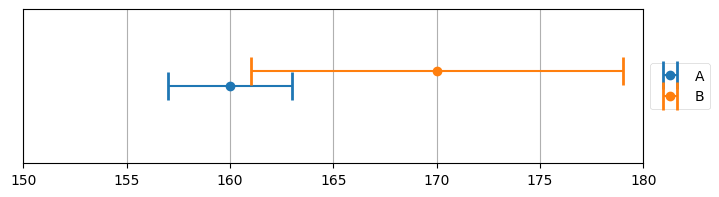

In [55]:
book_plots.plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

Sensor A returned a measurement of 160, and sensor B returned 170. The bars are [*error bars*](https://en.wikipedia.org/wiki/Error_bar) - they illustrate the possible range of error for the measurement. Hence, the actual value that A is measuring can be between 157 to 163, and B is measuring a value between 161 to 179.

I did not define it at the time, but this is a [*uniform distribution*](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous&#41;). A uniform distribution assigns equal probability to any event in the range. According to this model it is equally likely for sensor A to read 157, 160, or 163. Any value outside these ranges have 0 probability. 

We can model this situation with Gaussians. I'll use $\mathcal{N}(160, 3^2)$ for sensor A, and $\mathcal{N}(170, 9^2)$ for sensor B. I've plotted these below with the uniform distribution error bars for comparison.

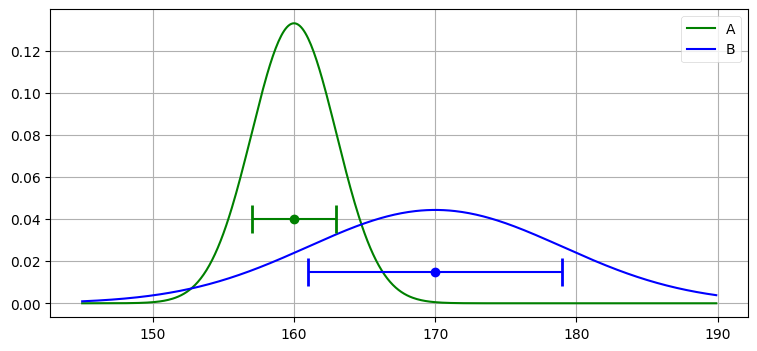

In [56]:
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
plt.plot(xs, ys, label='A', color='g')

ys = [stats.gaussian(x, 170, 9**2) for x in xs]
plt.plot(xs, ys, label='B', color='b')
plt.legend();
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='g', capthick=2, capsize=10)    
plt.errorbar(170, [0.015], xerr=[9], fmt='o', color='b', capthick=2, capsize=10);

Using a uniform or Gaussian distribution is a modeling choice. Neither exactly describes reality. In most cases the Gaussian distribution is more realistic. Most sensors are more likely to return readings near the value being measured, and unlikely to return a reading far from that value. The Gaussian models this tendency. In contrast the uniform distribution assumes that any measurement within a range is equally likely.

Now let's see the *discrete distribution* used in the discrete Bayes filter. This model divides the range of possible values into discrete ranges and assigns a probability to each bucket. This assignment can be entirely arbitrary so long as the probabilities sum to one.

Let's plot the data for one sensor using a uniform distribution, a Gaussian distribution, and a discrete distribution.

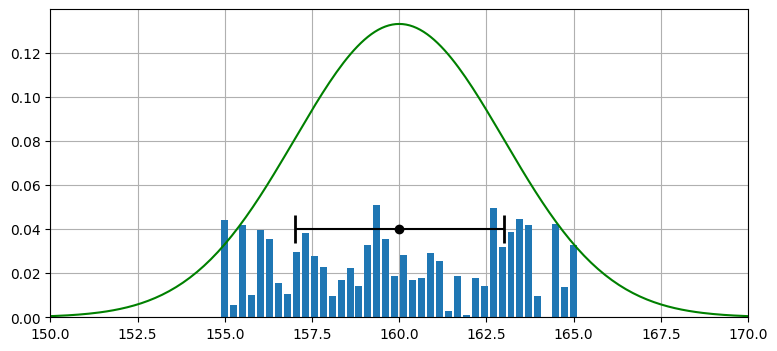

In [26]:
from random import random
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
belief = np.array([random() for _ in range(40)])
belief = belief / sum(belief)

x = np.linspace(155, 165, len(belief))
plt.gca().bar(x, belief, width=0.2)
plt.plot(xs, ys, label='A', color='g')
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='k', capthick=2, capsize=10)    
plt.xlim(150, 170);

I used random numbers to form the discrete distribution to illustrate that it can model any arbitrary probability distribution. This provides it with enormous power. With enough discrete buckets we can model the error characteristics of any sensor no matter how complicated. But with this power comes mathematical intractability. Multiplying or adding Gaussians takes two lines of math, and the result is another Gaussian. This regularity allows us to perform powerful analysis on the performance and behavior of our filters. Multiplying or adding a discrete distribution requires looping over the data, and we have no easy way to characterize the result.  Analyzing the performance characteristics of a filter based on a discrete distribution is extremely difficult to impossible.

There is no 'correct' choice here. Later in the book we will introduce the *particle filter* which uses a discrete distribution. It is an extremely powerful technique because it can handle arbitrarily complex situations. This comes at the cost of slow performance, and resistance to analytical analysis. 

For now we will ignore these matters and return to using Gaussians for the next several chapters. As we progress you will learn the strengths and limitations of using Gaussians in our mathematical models.

## Introduction to Designing a Filter

So far we have developed filters for a position sensor. We are used to this problem by now, and may feel ill-equipped to implement a Kalman filter for a different problem. To be honest, there is still quite a bit of information missing from this presentation. Following chapters will fill in the gaps. Still, let's get a feel for it by designing and implementing a Kalman filter for a thermometer. The sensor for the thermometer outputs a voltage that corresponds to the temperature that is being measured. We have read the manufacturer's specifications for the sensor, and it tells us that the sensor exhibits white noise with a standard deviation of 0.13 volts.

We can simulate the temperature sensor measurement with this function:

In [57]:
def volt(voltage, std):
    return voltage + (randn() * std)

Now we need to write the Kalman filter processing loop. As with our previous problem, we need to perform a cycle of predicting and updating. The sensing step probably seems clear - call `volt()` to get the measurement, pass the result into `update()` method, but what about the predict step? We do not have a sensor to detect 'movement' in the voltage, and for any small duration we expect the voltage to remain constant. How shall we handle this?

As always, we will trust in the math. We have no known movement, so we will set that to zero. However, that means that we are predicting that the temperature will never change. If that is true, then over time we should become extremely confident in our results. Once the filter has enough measurements it will become very confident that it can predict the subsequent temperatures, and this will lead it to ignoring measurements that result due to an actual temperature change. This is called a *smug* filter, and is something you want to avoid. So we will add a bit of error to our prediction step to tell the filter not to discount changes in voltage over time. In the code below I set `process_var = .05**2`. This is the expected variance in the change of voltage over each time step. I chose this value merely to be able to show how the variance changes through the update and predict steps. For a real sensor you would set this value for the actual amount of change you expect. For example, this would be an extremely small number if it is a thermometer for ambient air temperature in a house, and a high number if this is a thermocouple in a chemical reaction chamber. We will say more about selecting the actual value in the later chapters.

Let's see what happens. 

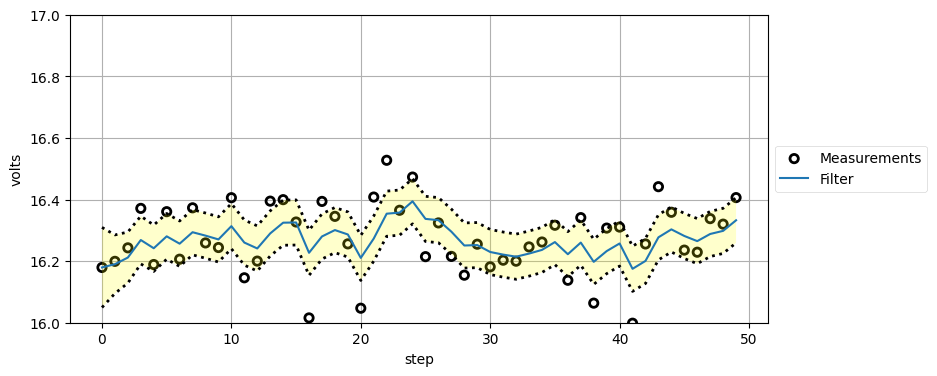

Variance converges to 0.005


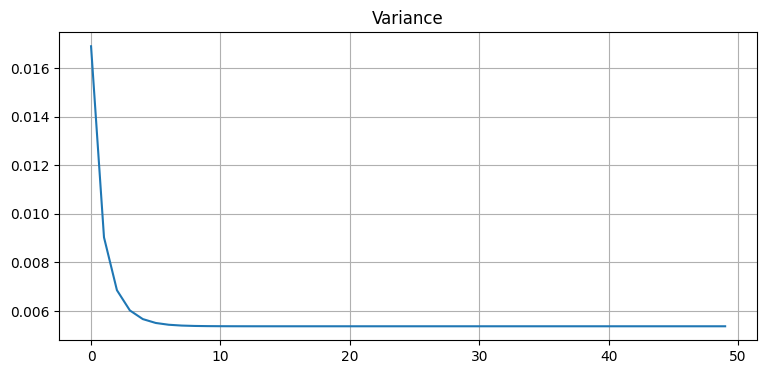

In [58]:
temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

# plot the filter output and the variance
book_plots.plot_measurements(zs)
book_plots.plot_filter(estimates, var=np.array(ps))
book_plots.show_legend()
plt.ylim(16, 17)
book_plots.set_labels(x='step', y='volts')
plt.show()
    
plt.plot(ps)
plt.title('Variance')
print(f'Variance converges to {ps[-1]:.3f}')

The first plot shows the individual sensor measurements vs the filter output. Despite a lot of noise in the sensor we quickly discover the approximate voltage of the sensor. In the run I just completed at the time of authorship, the last voltage output from the filter is $16.213$, which is quite close to the $16.4$ used by the `volt()` function. On other runs I have gotten larger and smaller results.

Spec sheets are what they sound like - specifications. Any individual sensor will exhibit different performance based on normal manufacturing variations. Values are often maximums - the spec is a guarantee that the performance will be at least that good. If you buy an expensive piece of equipment it often comes with a sheet of paper displaying the test results of your specific item; this is usually very trustworthy. On the other hand, if this is a cheap sensor it is likely it received little to no testing prior to being sold. Manufacturers typically test a small subset of their output to verify that a sample falls within the desired performance range. If you have a critical application you will need to read the specification sheet carefully to figure out exactly what they mean by their ranges. Do they guarantee their number is a maximum, or is it, say, the $3\sigma$ error rate? Is every item tested? Is the variance normal, or some other distribution? Finally, manufacturing is not perfect. Your part might be defective and not match the performance on the sheet.

For example, I am looking at a data sheet for an airflow sensor. There is a field *Repeatability*, with the value $\pm 0.50\%$. Is this a Gaussian? Is there a bias? For example, perhaps the repeatability is nearly $0.0\%$ at low temperatures, and always nearly  $+0.50\%$ at high temperatures. Data sheets for electrical components often contain a section of "Typical Performance Characteristics". These are used to capture information that cannot be easily conveyed in a table. For example, I am looking at a chart showing output voltage vs current for a LM555 timer. There are three curves showing the performance at different temperatures. The response is ideally linear, but all three lines are curved. This clarifies that errors in voltage outputs are probably not Gaussian - in this chip's case higher temperatures lead to lower voltage output, and the voltage output is quite nonlinear if the input current is very high. 

As you might guess, modeling the performance of your sensors is one of the harder parts of creating a Kalman filter that performs well. 

### Animation

For those reading this in a browser here is an animation showing the filter working. If you are not using a browser you can see this plot at https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/animations/05_volt_animate.gif.

<img src='animations/05_volt_animate.gif'>

The top plot in the animation draws a green line for the predicted next voltage, then a red '+' for the actual measurement, draws a light red line to show the residual, and then draws a blue line to the filter's output. You can see that when the filter starts the corrections made are quite large, but after only a few updates the filter only adjusts its output by a small amount even when the measurement is far from it. 

The lower plot shows the Gaussian belief as the filter innovates. When the filter starts the Gaussian curve is centered over 25, our initial guess for the voltage, and is very wide and short due to our initial uncertainty. But as the filter innovates, the Gaussian quickly moves to about 16.0 and becomes taller, reflecting the growing confidence that the filter has in it's estimate for the voltage. You will also note that the Gaussian's height bounces up and down a little bit. If you watch closely you will see that the Gaussian becomes a bit shorter and more spread out during the prediction step, and becomes taller and narrower as the filter incorporates another measurement.

Think of this animation in terms of the g-h filter. At each step the g-h filter makes a prediction, takes a measurement, computes the residual (the difference between the prediction and the measurement), and then selects a point on the residual line based on the scaling factor $g$. The Kalman filter is doing exactly the same thing, except that the scaling factor $g$ varies with time. As the filter becomes more confident in its state the scaling factor favors the filter's prediction over the measurement. 

## Example: Extreme Amounts of Noise

With the dog filter I didn't put a lot of noise in the signal, and I 'guessed' that the dog was at position 0. How does the filter perform in real world conditions? I will start by injecting more noise in the RFID sensor while leaving the process variance at 2 m$^2$.  I will inject an extreme amount of noise - noise that apparently swamps the actual measurement. What does your intuition say about the filter's performance if the sensor has a standard deviation of 300 meters? In other words, an actual position of 1.0 m might be reported as 287.9 m, or -589.6 m, or any other number in roughly that range. Think about it before you scroll down.

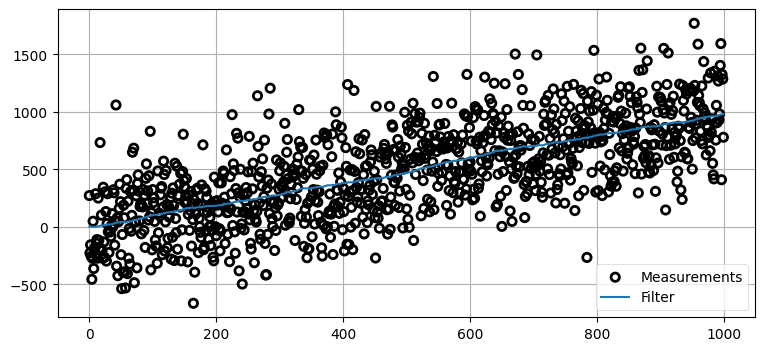

In [59]:
sensor_var = 300.**2
process_var = 2.
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 1000
dog = DogSimulation(pos.mean, 1., sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

In this example the noise is extreme yet the filter still outputs a nearly straight line! This is an astonishing result! What do you think might be the cause of this performance? 

We get a nearly straight line because our process error is small. A small process error tells the filter that the prediction is very trustworthy, and the prediction is a straight line, so the filter outputs a nearly straight line. 

## Example: Incorrect Process Variance

That last filter looks fantastic! Why wouldn't we set the process variance very low, as it guarantees the result will be straight and smooth?

The process variance tells the filter how much the system is changing over time. If you lie to the filter by setting this number artificially low the filter will not be able to react to changes that are happening. Let's have the dog increase his velocity by a small amount at each time step and see how the filter performs with a process variance of 0.001 m$^2$.

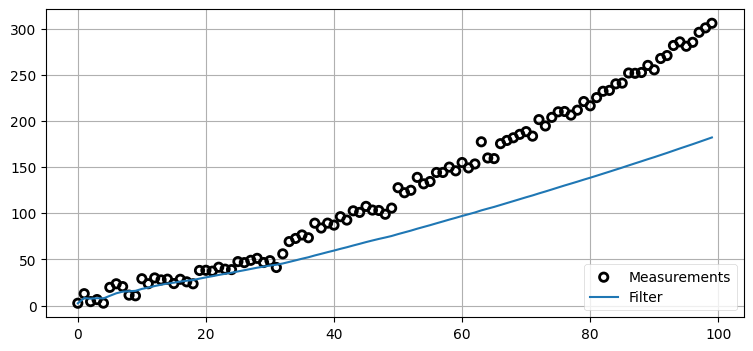

In [66]:
sensor_var = 20.
process_var = .001
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 100
dog = DogSimulation(pos.mean, 1, sensor_var, process_var*10000)
zs, ps = [], []
for _ in range(N):
    dog.velocity += 0.04
    zs.append(dog.move_and_sense())

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

It is easy to see that the filter is not correctly responding to the measurements. The measurements  clearly indicate that the dog is changing speed but the filter has been told that it's predictions are nearly perfect so it almost entirely ignores them. I encourage you to adjust the amount of movement in the dog vs process variance. We will also be studying this topic much more in the later chapters. The key point is to recognize that math requires that the variances correctly describe your system. The filter does not 'notice' that it is diverging from the measurements and correct itself. It computes the Kalman gain from the variance of the prior and the measurement, and forms the estimate depending on which is more accurate.

## Example: Bad Initial Estimate


Now let's look at the results when we make a bad initial estimate of position. To avoid obscuring the results I'll reduce the sensor variance to 30, but set the initial position to 1000 meters. Can the filter recover from a 1000 meter error?

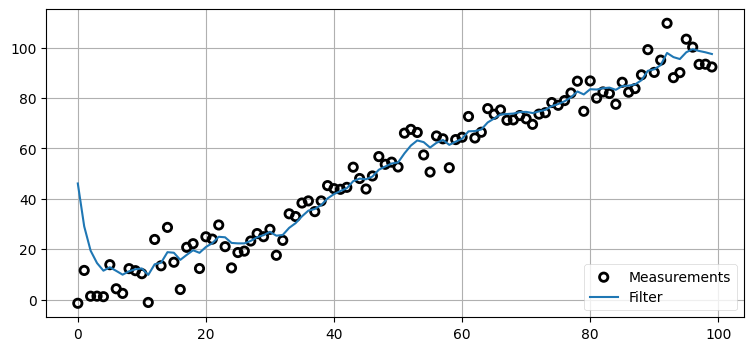

In [67]:
sensor_var = 5.**2
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)
N = 100
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

Again the answer is yes! Because we are relatively sure about our belief in the sensor ($\sigma^2=5^2$) after only the first step we have changed our position estimate from 1000 m to roughly 50 m. After another 5-10 measurements we have converged to the correct value. This is how we get around the chicken and egg problem of initial guesses. In practice we would likely assign the first measurement from the sensor as the initial value, but you can see it doesn't matter much if we wildly guess at the initial conditions - the Kalman filter still converges so long as the filter variances are chosen to match the actual process and measurement variances.

## Example: Large Noise and Bad Initial Estimate

What about the worst of both worlds, large noise and a bad initial estimate?

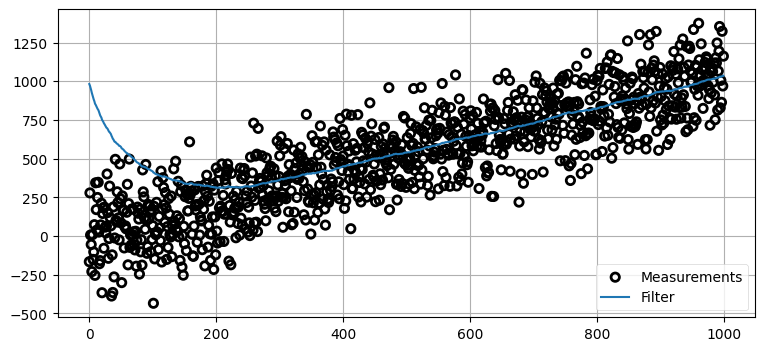

In [68]:
sensor_var = 30000.
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)

N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

This time the filter struggles. Notice that the previous example only computed 100 updates, whereas this example uses 1000. By my eye it takes the filter 400 or so iterations to become reasonable accurate, but maybe over 600 before the results are good. Kalman filters are good, but we cannot expect miracles. If we have extremely noisy data and extremely bad initial conditions, this is as good as it gets.

Finally, let's implement the suggestion of using the first measurement as the initial position.

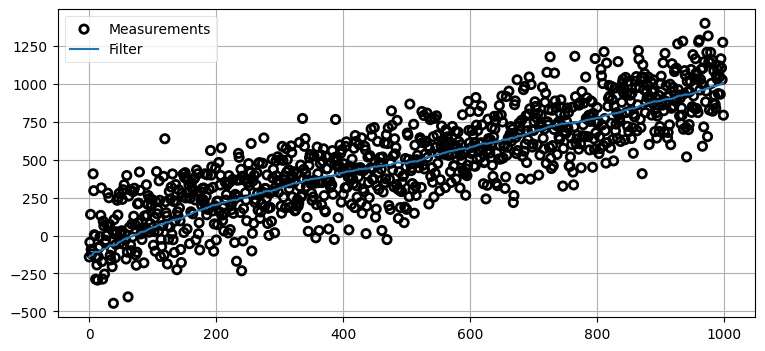

In [69]:
sensor_var = 30000.
process_var = 2.
process_model = gaussian(1., process_var)
N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

pos = gaussian(zs[0], 500.)
ps = []
for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc='best');

This simple change significantly improves the results. On some runs it takes 200 iterations or so to settle to a good solution, but other runs it converges very rapidly. This all depends on the amount of noise in the first measurement. A large amount of noise causes the initial estimate to be far from the dog's position.

200 iterations may seem like a lot, but the amount of noise we are injecting is truly huge. In the real world we use sensors like thermometers,  laser range finders, GPS satellites, computer vision, and so on. None have the enormous errors in these examples. A reasonable variance for a cheap thermometer might be 0.2 C$^{\circ 2}$, and our code is using 30,000 C$^{\circ 2}$.

## Exercise: Interactive Plots

Implement the Kalman filter using Jupyter Notebook's animation features to allow you to modify the various constants in real time using sliders. Refer to the section **Interactive Gaussians** in the **Gaussians** chapter to see how to do this. You will use the `interact()` function to call a calculation and plotting function. Each parameter passed into `interact()` automatically gets a slider created for it. I have written the boilerplate for this; you fill in the required code.

In [70]:
from ipywidgets import interact
from kf_book.book_plots import FloatSlider

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity, 
                       process_noise):
    plt.figure();
    # your code goes here

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0, max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=5, min=0, max=100.));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

### Solution

One possible solution follows. We have sliders for the start position, the amount of noise in the sensor, the amount we move in each time step, and how much movement error there is. Process noise is perhaps the least clear - it models how much the dog wanders off course at each time step, so we add that into the dog's position at each step. I set the random number generator seed so that each redraw uses the same random numbers, allowing us to compare the graphs as we move the sliders.

In [72]:
from numpy.random import seed 
from ipywidgets import interact

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity,
                       process_noise):
    N = 20
    zs, ps = [], []   
    seed(303)
    dog = DogSimulation(start_pos, velocity, sensor_noise, process_noise)
    zs = [dog.move_and_sense() for _ in range(N)]
    pos = gaussian(0., 1000.) # mean and variance
    process_model = gaussian(velocity, process_noise)
    
    for z in zs:    
        pos = predict(pos, process_model)
        pos = update(pos, gaussian(z, sensor_noise))
        ps.append(pos.mean)

    plt.figure()
    plt.plot(zs, c='k', marker='o', linestyle='', label='measurement')
    plt.plot(ps, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc=4);
    plt.show()

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0., max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=.1, min=0, max=40));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

## Exercise - Nonlinear Systems

Our equations for the Kalman filter are linear:

$$\begin{aligned}
\mathcal{N}(\bar\mu,\, \bar\sigma^2) &= \mathcal{N}(\mu,\, \sigma^2) + \mathcal{N}(\mu_\mathtt{move},\, \sigma^2_\mathtt{move})\\
\mathcal{N}(\mu,\, \sigma^2) &= \mathcal{N}(\bar\mu,\, \bar\sigma^2)  \times \mathcal{N}(\mu_\mathtt{z},\, \sigma^2_\mathtt{z})
\end{aligned}$$

Do you suppose that this filter works well or poorly with nonlinear systems?

Implement a Kalman filter that uses the following equation to generate the measurement value

```python
for i in range(100):
    z = math.sin(i/3.) * 2
```
    
Adjust the variance and initial positions to see the effect. What is, for example, the result of a very bad initial guess?

In [35]:
#enter your code here.

### Solution

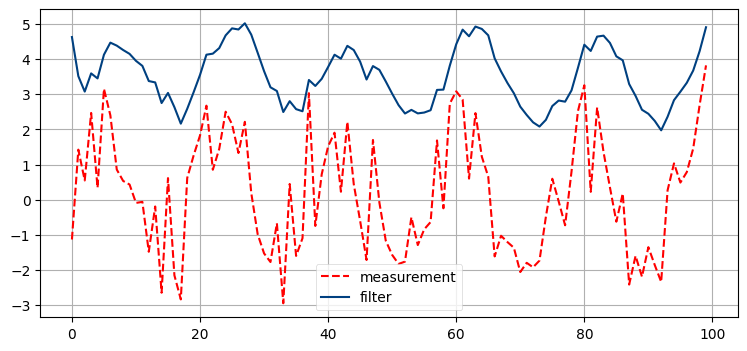

In [73]:
import math

sensor_var = 30.
process_var = 2.
pos = gaussian(100., 500.)
process_model = gaussian(1., process_var)

zs, ps = [], []

for i in range(100):
    pos = predict(pos, process_model)

    z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(z)
    
    pos = update(pos, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.plot(zs, c='r', linestyle='dashed', label='measurement')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

### Discussion

This is terrible! The output is not at all like a sin wave, except in the grossest way. With linear systems we could add extreme amounts of noise to our signal and still extract a very accurate result, but here even modest noise creates a very bad result.

If we recall the **g-h Filter** chapter we can understand what is happening here. The structure of the g-h filter requires that the filter output chooses a value part way between the prediction and measurement. A varying signal like this one is always accelerating, whereas our process model assumes constant velocity, so the filter is mathematically guaranteed to always lag the input signal. 

Very shortly after practitioners began implementing Kalman filters they recognized the poor performance of them for nonlinear systems and began devising ways of dealing with it. Later chapters are devoted to this problem.

## Fixed Gain Filters

Embedded computers usually have extremely limited processors. Many do not have floating point circuitry. These simple equations can impose a heavy burden on the chip. This is less true as technology advances, but do not underestimate the value of spending one dollar less on a processor when you will be buying millions of them.

In the example above the variance of the filter converged to a fixed value. This will always happen if the variance of the measurement and process is a constant. You can take advantage of this fact by running simulations to determine what the variance converges to. Then you can hard code this value into your filter. So long as you initialize the filter to a good starting guess (I recommend using the first measurement as your initial value) the filter will perform very well. For example, the dog tracking filter can be reduced to this:

```python
def update(x, z):
    K = .13232  # experimentally derived Kalman gain
    y = z - x   # residual
    x = x + K*y # posterior
    return x
    
def predict(x):
    return x + vel*dt
```

I used the Kalman gain form of the update function to emphasize that we do not need to consider the variances at all. If the variances converge to a single value so does the Kalman gain. 

## FilterPy's Implementation

FilterPy implements `predict()` and `update()`.  They work not only for the univariate case developed in this chapter, but the more general multivariate case that we learn in subsequent chapters. Because of this their interface is slightly different. They do not take Gaussians as tuples, but as two separately named variables.

`predict()` takes several arguments, but we will only need to use these four:

```python
predict(x, P, u, Q)
```

`x` is the state of the system. `P` is the variance of the system. `u` is the movement due to the process, and `Q` is the noise in the process. You will need to used named arguments when you call `predict()` because most of the arguments are optional. The third argument to `predict()` is **not** `u`.

These may strike you as terrible variable names. They are! As I already mentioned they come from a long history of control theory, and every paper or book you read will use these names. So, we just have to get used to it. Refusing to memorize them means you will never be able to read the literature.

Let's try it for the state $\mathcal N(10, 3)$ and the movement $\mathcal N(1, 4)$. We'd expect a final position of 11 (10+1) with a variance of 7 (3+4).

In [37]:
import filterpy.kalman as kf
kf.predict(x=10., P=3., u=1., Q=4.)

(11.0, 7.0)

`update` also takes several arguments, but for now you will be interested in these four:
 
```python
update(x, P, z, R)
```
 
As before, `x` and `P` are the state and variance of the system. `z` is the measurement, and `R` is the measurement variance. Let's perform the last predict statement to get our prior, and then perform an update:

In [38]:
x, P = kf.predict(x=10., P=3., u=1., Q=2.**2)
print(f'{x:.3f}')

x, P = kf.update(x=x, P=P, z=12., R=3.5**2)
print(f'{x:.3f} {P:.3f}')

11.000
11.364 4.455


I gave it a noisy measurement with a big variance, so the estimate remained close to the prior of 11.

One final point. I did not use the variable name `prior` for the output of the predict step. I will not use that variable name in the rest of the book. The Kalman filter equations just use $\mathbf x$. Both the prior and the posterior are the estimated state of the system, the former is the estimate before the measurement is incorporated, and the latter is after the measurement has been incorporated.

## Summary

The Kalman filter that we describe in this chapter is a special, restricted case of the more general filter we will learn next. Most texts do not discuss this one dimensional form. However, I think it is a vital stepping stone. We started the book with the g-h filter, then implemented the discrete Bayes filter, and now implemented the one dimensional Kalman filter. I have tried to show you that each of these filters use the same algorithm and reasoning. The mathematics of the Kalman filter that we will learn shortly is fairly sophisticated, and it can be difficult to understand the underlying simplicity of the filter. That sophistication comes with significant benefits: the generalized filter will markedly outperform the filters in this chapter.

This chapter takes time to assimilate. To truly understand it you will probably have to work through this chapter several times. I encourage you to change the various constants in the code and observe the results. Convince yourself that Gaussians are a good representation of a unimodal belief of  the position of a dog in a hallway, the position of an aircraft in the sky, or the temperature of a chemical reaction chamber. Then convince yourself that multiplying Gaussians truly does compute a new belief from your prior belief and the new measurement. Finally, convince yourself that if you are measuring movement, that adding the Gaussians together updates your belief. 

Most of all, spend enough time with the **Full Description of the Algorithm** section to ensure you understand the algorithm and how it relates to the g-h filter and discrete Bayes filter. There is just one 'trick' here - selecting a value somewhere between a prediction and a measurement. Each algorithm performs that trick with different math, but all use the same logic.